In [1]:
import numpy as np
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

img_files = np.array(glob("Data/*/*/*"))
print('%d total images' % len(img_files))

893 total images


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([transforms.Resize(size=(244, 244)),
                                    transforms.ToTensor()])
    img = transform(img)[:3,:,:].unsqueeze(0)
    return img

In [3]:
import os
import torch
from torchvision import datasets
from torch.utils.data import Dataset

num_workers = 0
batch_size = 20

# from the pytorch torchvision models documentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(256),
                                      transforms.RandomAffine(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.RandomRotation(120),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      normalize])
test_transform = transforms.Compose([transforms.Resize(size=(256, 256)),
                                     transforms.ToTensor(),
                                     normalize])
valid_transform = transforms.Compose([transforms.Resize(320),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      normalize])


train_data = datasets.ImageFolder('Data/Train', transform=train_transform)
test_data = datasets.ImageFolder('Data/Test', transform=test_transform)
valid_data = datasets.ImageFolder('Data/Valid', transform=valid_transform)


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=num_workers)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

# CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(8*8*128, 500)
        self.fc2 = nn.Linear(500, 33)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 8*8*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x

model_scratch = Net()

if use_cuda:
    model_scratch.cuda()

In [5]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

In [6]:
loaders_scratch = {
    'train': train_loader,
    'test': test_loader,
    'valid': valid_loader
}

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find loss and update model parameters

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                
        # validate the model #

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss))
            
        # save model if validation loss decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [8]:
# train model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load model with best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 3.495144 	Validation Loss: 3.483835
Validation loss decreased (inf --> 3.483835).  Saving model ...
Epoch: 2 	Training Loss: 3.464611 	Validation Loss: 3.428536
Validation loss decreased (3.483835 --> 3.428536).  Saving model ...
Epoch: 3 	Training Loss: 3.409653 	Validation Loss: 3.355284
Validation loss decreased (3.428536 --> 3.355284).  Saving model ...
Epoch: 4 	Training Loss: 3.334465 	Validation Loss: 3.292039
Validation loss decreased (3.355284 --> 3.292039).  Saving model ...
Epoch: 5 	Training Loss: 3.140541 	Validation Loss: 3.029476
Validation loss decreased (3.292039 --> 3.029476).  Saving model ...
Epoch: 6 	Training Loss: 3.121464 	Validation Loss: 2.963820
Validation loss decreased (3.029476 --> 2.963820).  Saving model ...
Epoch: 7 	Training Loss: 2.797502 	Validation Loss: 3.382300
Epoch: 8 	Training Loss: 2.634247 	Validation Loss: 2.653524
Validation loss decreased (2.963820 --> 2.653524).  Saving model ...
Epoch: 9 	Training Loss: 2.428906 

<All keys matched successfully>

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.103329


Test Accuracy:  7% ( 5/66)


In [10]:
class_names = [item[:] for item in loaders_scratch['train'].dataset.classes]

In [11]:
class_names[:5]

['AK-47', 'AWP', 'Aug', 'CZ-75', 'Famas']

In [12]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(256, 256)),
                                     transforms.ToTensor(), 
                                     normalize])
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [13]:
def predict_gun_scratch(model, class_names, img_path):
    # load image and return predicted gun
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [14]:
import matplotlib.pyplot as plt                        
%matplotlib inline

def run_app(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    predict = predict_gun_scratch(model_scratch, class_names, img_path)
    print('This gun looks like a(n) {}'.format(predict))

In [15]:
loaders_transfer = loaders_scratch.copy()

In [16]:
import torchvision.models as models
import torch.nn as nn

# transfer model 
model_transfer = models.resnext101_32x8d(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, 33)

for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

In [17]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        
        model_transfer.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find loss and update model parameters

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
               
        # validate the model #
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss))
            
        
        # save model if validation loss decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [20]:
train(100, loaders_transfer, model_transfer, optimizer_transfer,
      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.492337 	Validation Loss: 3.291725
Validation loss decreased (inf --> 3.291725).  Saving model ...
Epoch: 2 	Training Loss: 2.643337 	Validation Loss: 2.685088
Validation loss decreased (3.291725 --> 2.685088).  Saving model ...
Epoch: 3 	Training Loss: 2.147937 	Validation Loss: 2.516742
Validation loss decreased (2.685088 --> 2.516742).  Saving model ...
Epoch: 4 	Training Loss: 1.783804 	Validation Loss: 2.150797
Validation loss decreased (2.516742 --> 2.150797).  Saving model ...
Epoch: 5 	Training Loss: 1.406424 	Validation Loss: 2.106912
Validation loss decreased (2.150797 --> 2.106912).  Saving model ...
Epoch: 6 	Training Loss: 1.208184 	Validation Loss: 1.998868
Validation loss decreased (2.106912 --> 1.998868).  Saving model ...
Epoch: 7 	Training Loss: 1.071027 	Validation Loss: 1.782086
Validation loss decreased (1.998868 --> 1.782086).  Saving model ...
Epoch: 8 	Training Loss: 0.967357 	Validation Loss: 1.609753
Validation loss decreased (1.78208

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [21]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.201693


Test Accuracy: 45% (30/66)


In [22]:
def predict_gun_transfer(model, class_names, img_path):
    # load the image and return the predicted gun
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [23]:
def run_app_transfer(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    predict = predict_gun_transfer(model_transfer, class_names, img_path)
    print('This gun looks like a(n) {}'.format(predict))

In [24]:
test_imgs = np.array(glob("Data/Test/*/*"))
train_imgs = np.array(glob('Data/Train/*/*'))

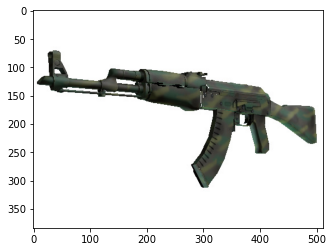

This gun looks like a(n) AK-47


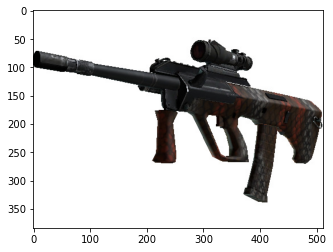

This gun looks like a(n) Aug


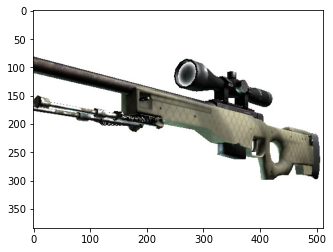

This gun looks like a(n) M4A1


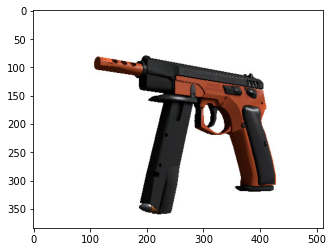

This gun looks like a(n) CZ-75


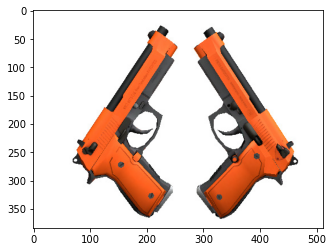

This gun looks like a(n) MP-9


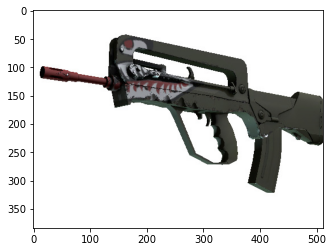

This gun looks like a(n) Famas


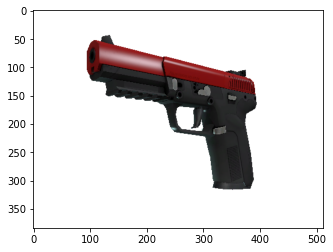

This gun looks like a(n) Mag-7


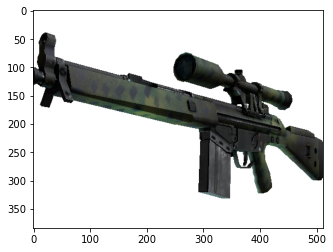

This gun looks like a(n) Sawed-Off


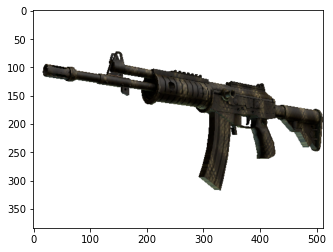

This gun looks like a(n) Galil-AR


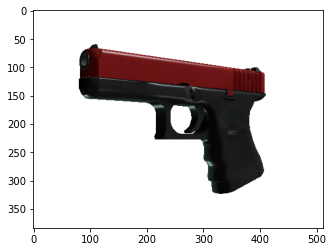

This gun looks like a(n) Mag-7


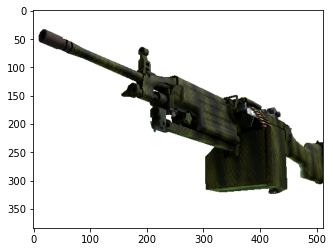

This gun looks like a(n) M4A1


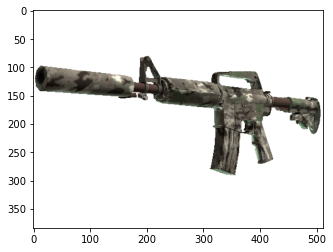

This gun looks like a(n) M4A1


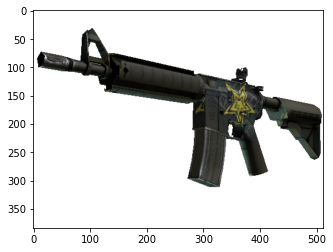

This gun looks like a(n) MP-9


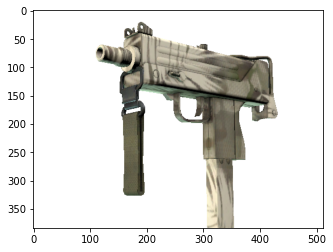

This gun looks like a(n) MAC-10


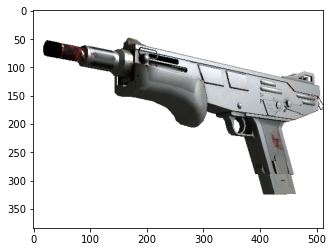

This gun looks like a(n) AK-47


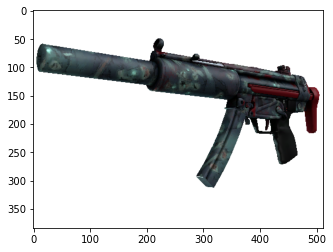

This gun looks like a(n) MP-5


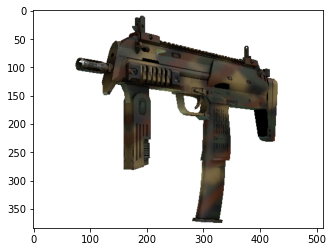

This gun looks like a(n) MP-9


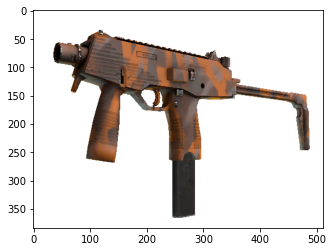

This gun looks like a(n) Aug


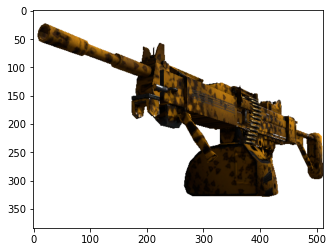

This gun looks like a(n) Tec-9


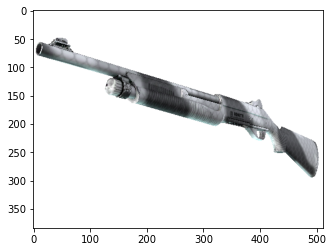

This gun looks like a(n) Nova


In [25]:
for path in test_imgs[:40:2]:
    run_app_transfer(path)

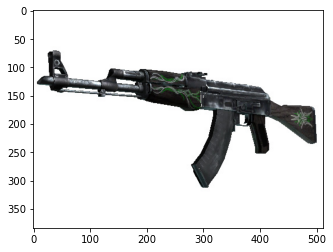

This gun looks like a(n) AK-47


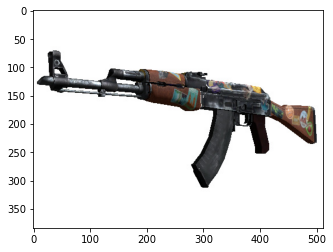

This gun looks like a(n) AK-47


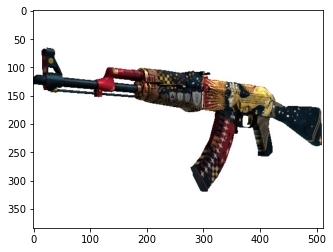

This gun looks like a(n) AK-47


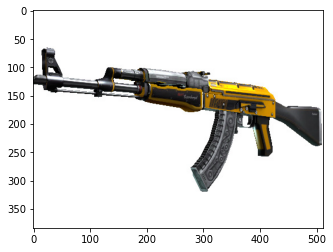

This gun looks like a(n) AK-47


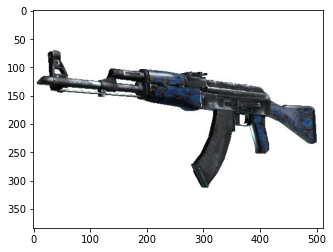

This gun looks like a(n) AK-47


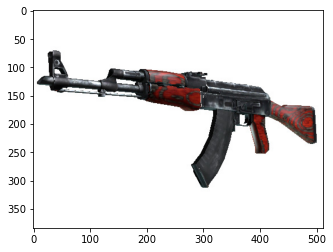

This gun looks like a(n) AK-47


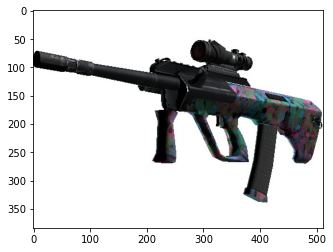

This gun looks like a(n) Aug


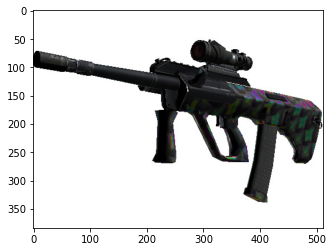

This gun looks like a(n) Aug


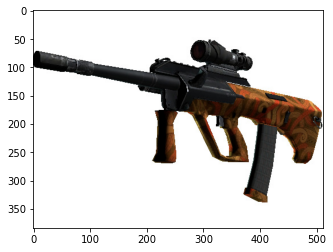

This gun looks like a(n) Aug


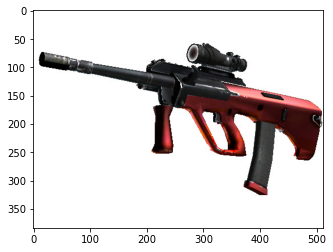

This gun looks like a(n) Galil-AR


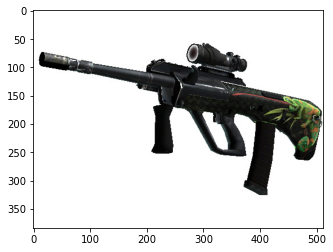

This gun looks like a(n) Aug


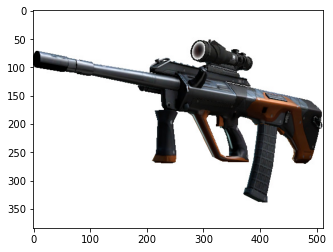

This gun looks like a(n) Aug


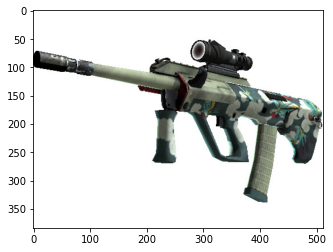

This gun looks like a(n) M4A1


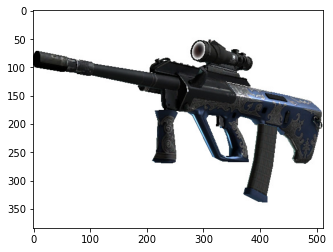

This gun looks like a(n) Galil-AR


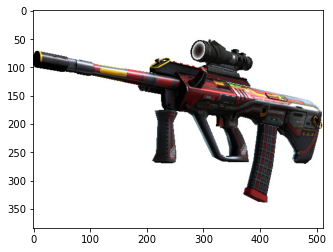

This gun looks like a(n) AK-47


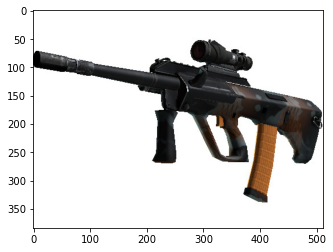

This gun looks like a(n) Aug


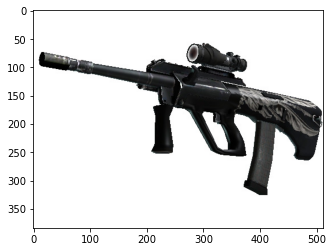

This gun looks like a(n) Aug


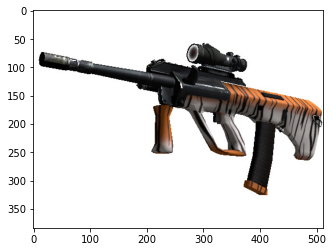

This gun looks like a(n) Aug


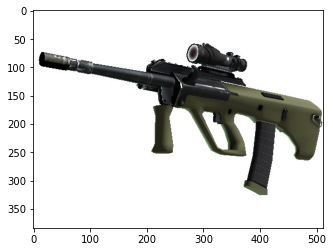

This gun looks like a(n) Aug


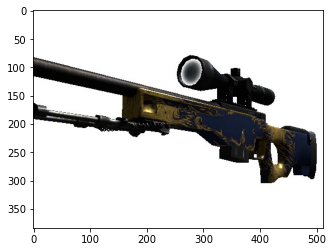

This gun looks like a(n) M4A1


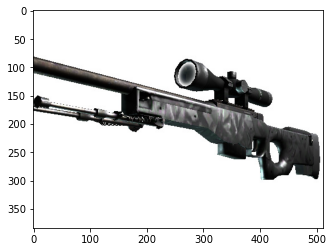

This gun looks like a(n) M4A1


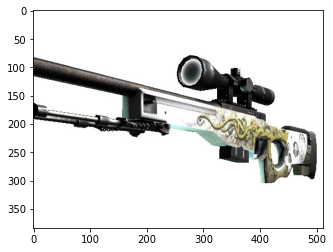

This gun looks like a(n) Scout


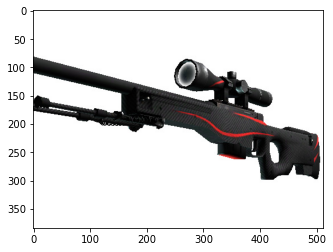

This gun looks like a(n) M4A1


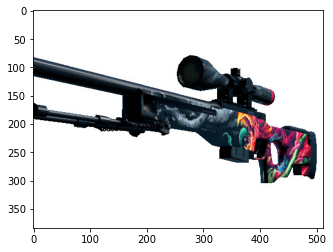

This gun looks like a(n) M4A1


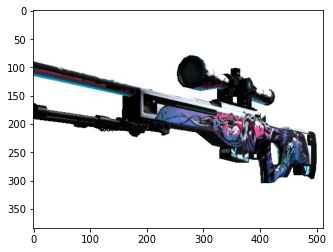

This gun looks like a(n) AK-47


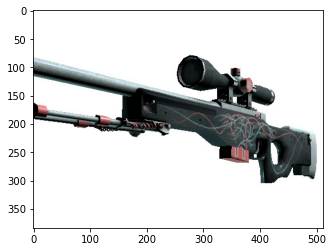

This gun looks like a(n) AWP


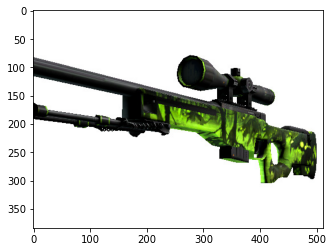

This gun looks like a(n) Sawed-Off


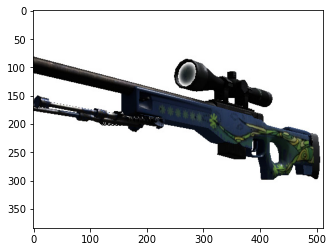

This gun looks like a(n) M4A1


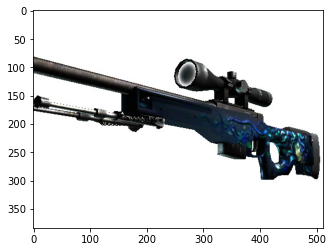

This gun looks like a(n) Sawed-Off


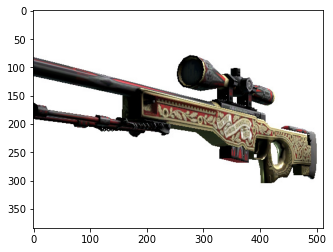

This gun looks like a(n) AWP


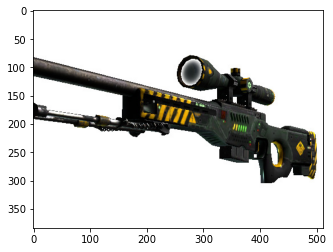

This gun looks like a(n) M4A1


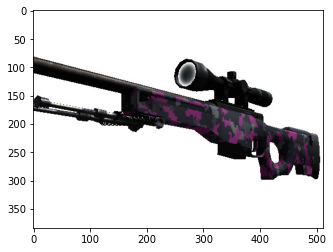

This gun looks like a(n) Galil-AR


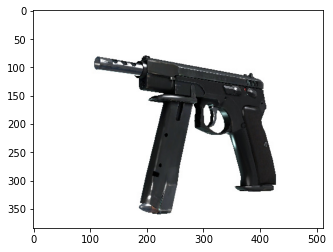

This gun looks like a(n) AK-47


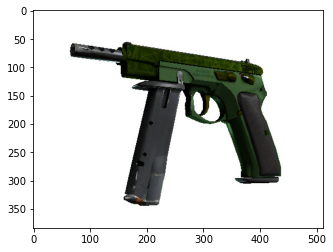

This gun looks like a(n) Five_Seven


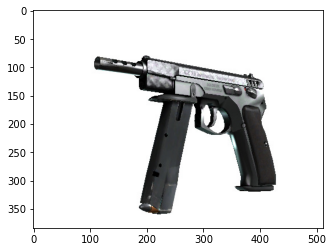

This gun looks like a(n) AK-47


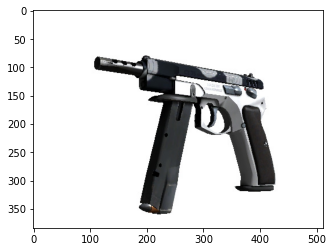

This gun looks like a(n) Five_Seven


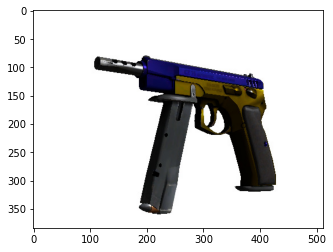

This gun looks like a(n) CZ-75


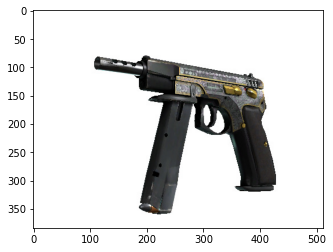

This gun looks like a(n) AK-47


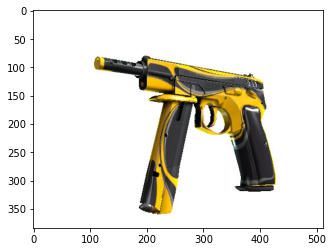

This gun looks like a(n) Sawed-Off


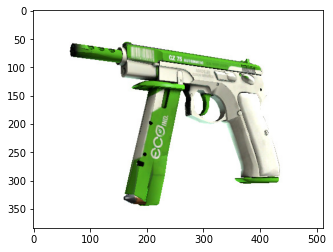

This gun looks like a(n) Sawed-Off


In [26]:
for path in train_imgs[20:100:2]:
    run_app_transfer(path)